In [1]:
# Importar bibliotecas necesarias
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count, isnan, when, trim, to_timestamp, datediff, current_date, unix_timestamp,col, udf, when
from pyspark.sql.types import StringType, IntegerType, FloatType, TimestampType
from pyspark.sql.window import Window

1. Crear y inicializar SPARK

In [2]:
# Inicializar SparkSession
spark = SparkSession.builder \
    .appName("Marketin-predictivo") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

2. Leer los datasets

In [3]:
# Caminos para los archivos
path_clientes = "/home/jovyan/Marketing-Predictivo/CSV/clientes_anonimizados.csv"
path_produtos = "/home/jovyan/Marketing-Predictivo/CSV/productos_con_atributos.csv"
path_ordens = "/home/jovyan/Marketing-Predictivo/CSV/historico_ordenes.csv"

In [4]:
df_clientes = spark.read.csv(path_clientes, header=True, inferSchema=True, sep=',')
df_clientes.printSchema()
df_clientes.show(5, truncate=False)

root
 |-- user_id: integer (nullable = true)
 |-- user_registered: string (nullable = true)
 |-- user_status: integer (nullable = true)
 |-- billing_city: string (nullable = true)
 |-- billing_country: string (nullable = true)
 |-- billing_state: string (nullable = true)

+-------+-------------------+-----------+------------+---------------+-------------+
|user_id|user_registered    |user_status|billing_city|billing_country|billing_state|
+-------+-------------------+-----------+------------+---------------+-------------+
|4      |2024-04-05 15:38:09|0          |Lima        |PE             |LMA          |
|8      |2024-04-12 16:09:39|0          |AREQUIPA    |PE             |ARE          |
|10     |2024-04-12 17:03:18|0          |LIMA        |PE             |LIM          |
|13     |2024-04-15 22:08:21|0          |Arequipa    |PE             |ARE          |
|14     |2024-04-15 22:16:09|0          |NULL        |NULL           |NULL         |
+-------+-------------------+-----------+------

In [5]:
df_produtos = spark.read.csv(path_produtos, header=True, inferSchema=False, sep=',', multiLine=True, escape='"')
df_produtos = df_produtos.withColumn("product_id", col("product_id").cast(IntegerType())) \
                       .withColumn("_price", col("_price").cast(FloatType())) \
                       .withColumn("_regular_price", col("_regular_price").cast(FloatType())) \
                       .withColumn("_sale_price", col("_sale_price").cast(FloatType())) \
                       .withColumn("total_sales", col("total_sales").cast(IntegerType())) \
                       .withColumn("_stock", col("_stock").cast(FloatType()))
df_produtos.printSchema()
df_produtos.show(10, truncate=True)

root
 |-- product_id: integer (nullable = true)
 |-- custom_partnumber: string (nullable = true)
 |-- post_title: string (nullable = true)
 |-- post_excerpt: string (nullable = true)
 |-- _sku: string (nullable = true)
 |-- _price: float (nullable = true)
 |-- _regular_price: float (nullable = true)
 |-- _sale_price: float (nullable = true)
 |-- total_sales: integer (nullable = true)
 |-- _backorders: string (nullable = true)
 |-- _stock: float (nullable = true)
 |-- _stock_status: string (nullable = true)
 |-- minimum_allowed_quantity: string (nullable = true)
 |-- custom_condition: string (nullable = true)
 |-- custom_eta: string (nullable = true)
 |-- custom_moq: string (nullable = true)
 |-- _product_attributes: string (nullable = true)
 |-- pa_1: string (nullable = true)
 |-- pa_almacenamiento: string (nullable = true)
 |-- pa_color: string (nullable = true)
 |-- pa_condicion: string (nullable = true)
 |-- pa_disco-duro: string (nullable = true)
 |-- pa_emmc: string (nullable = tr

In [6]:
df_produtos.show(10, truncate=True)

+----------+-----------------+--------------------+--------------------+-------------------+------+--------------+-----------+-----------+-----------+------+-------------+------------------------+----------------+----------+----------+--------------------+----+-----------------+--------+------------+-------------+-------+-----------+--------+--------------+-------------+-------------+------+--------------------+-------------------+----------+----------------+
|product_id|custom_partnumber|          post_title|        post_excerpt|               _sku|_price|_regular_price|_sale_price|total_sales|_backorders|_stock|_stock_status|minimum_allowed_quantity|custom_condition|custom_eta|custom_moq| _product_attributes|pa_1|pa_almacenamiento|pa_color|pa_condicion|pa_disco-duro|pa_emmc|pa_garantia|pa_marca|pa_memoria-ram|  pa_pantalla|pa_procesador|pa_ram|pa_sistema-operativo|pa_tarjeta-de-video|pa_teclado|pa_unidad-solida|
+----------+-----------------+--------------------+--------------------+

In [7]:
df_ordens = spark.read.csv(path_ordens, header=True, inferSchema=True, sep=',')
df_ordens.printSchema()
df_ordens.show(5, truncate=False)

root
 |-- order_id: integer (nullable = true)
 |-- order_date: string (nullable = true)
 |-- order_device_type: string (nullable = true)
 |-- order_session_visited_pages: integer (nullable = true)
 |-- order_session_start_time: string (nullable = true)
 |-- order_traffic_source_type: string (nullable = true)
 |-- order_utm_source_campaign: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_qty: integer (nullable = true)
 |-- product_net_revenue: double (nullable = true)
 |-- tax_amount: double (nullable = true)
 |-- product_gross_revenue: double (nullable = true)
 |-- status: string (nullable = true)

+--------+-------------------+-----------------+---------------------------+------------------------+-------------------------+-------------------------+----------+-----------+-----------+-------------------+----------+---------------------+------------+
|order_id|order_date         |order_device_type|order_session_

3. Limpieza y pré procesamiento de los datos

3.1 Dataset Clientes

In [8]:
# Verificar nulos
df_clientes.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clientes.columns]).show()

+-------+---------------+-----------+------------+---------------+-------------+
|user_id|user_registered|user_status|billing_city|billing_country|billing_state|
+-------+---------------+-----------+------------+---------------+-------------+
|      0|              0|          0|          13|             13|           14|
+-------+---------------+-----------+------------+---------------+-------------+



In [9]:
# Remover duplicatas basadas en el user_id
print(f"Registros antes de remover duplicatas (clientes): {df_clientes.count()}")
df_clientes = df_clientes.dropDuplicates(['user_id'])
print(f"Registros despues de remover duplicatas (clientes): {df_clientes.count()}")

Registros antes de remover duplicatas (clientes): 253
Registros despues de remover duplicatas (clientes): 253


In [10]:
# Normalizar columna de fecha 'user_registered.
df_clientes = df_clientes.withColumn("user_registered_ts", to_timestamp(col("user_registered"), "yyyy-MM-dd HH:mm:ss"))
df_clientes = df_clientes.withColumn("dias_desde_registro", datediff(current_date(), col("user_registered_ts")))
df_clientes.select("user_id", "user_registered", "user_registered_ts", "dias_desde_registro").show(5)

+-------+-------------------+-------------------+-------------------+
|user_id|    user_registered| user_registered_ts|dias_desde_registro|
+-------+-------------------+-------------------+-------------------+
|      4|2024-04-05 15:38:09|2024-04-05 15:38:09|                395|
|      8|2024-04-12 16:09:39|2024-04-12 16:09:39|                388|
|     10|2024-04-12 17:03:18|2024-04-12 17:03:18|                388|
|     13|2024-04-15 22:08:21|2024-04-15 22:08:21|                385|
|     14|2024-04-15 22:16:09|2024-04-15 22:16:09|                385|
+-------+-------------------+-------------------+-------------------+
only showing top 5 rows



3.2 Dataset Produtos

In [11]:
df_produtos.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_produtos.columns]).show()

+----------+-----------------+----------+------------+----+------+--------------+-----------+-----------+-----------+------+-------------+------------------------+----------------+----------+----------+-------------------+----+-----------------+--------+------------+-------------+-------+-----------+--------+--------------+-----------+-------------+------+--------------------+-------------------+----------+----------------+
|product_id|custom_partnumber|post_title|post_excerpt|_sku|_price|_regular_price|_sale_price|total_sales|_backorders|_stock|_stock_status|minimum_allowed_quantity|custom_condition|custom_eta|custom_moq|_product_attributes|pa_1|pa_almacenamiento|pa_color|pa_condicion|pa_disco-duro|pa_emmc|pa_garantia|pa_marca|pa_memoria-ram|pa_pantalla|pa_procesador|pa_ram|pa_sistema-operativo|pa_tarjeta-de-video|pa_teclado|pa_unidad-solida|
+----------+-----------------+----------+------------+----+------+--------------+-----------+-----------+-----------+------+-------------+------

In [13]:
# Remover duplicatas basadas en product_id
print(f"Registros antes da remoção de duplicatas (produtos): {df_produtos.count()}")
df_produtos = df_produtos.dropDuplicates(['product_id'])
print(f"Registros após a remoção de duplicatas (produtos): {df_produtos.count()}")

Registros antes da remoção de duplicatas (produtos): 5823
Registros após a remoção de duplicatas (produtos): 5823


In [19]:
df_produtos.show(5)

+----------+-----------------+--------------------+--------------------+------------------+------+--------------+-----------+-----------+-----------+------+-------------+------------------------+----------------+----------+----------+--------------------+----+-----------------+--------+------------+-------------+-------+-----------+--------+--------------+-------------+-------------+------+--------------------+--------------------+----------+----------------+
|product_id|custom_partnumber|          post_title|        post_excerpt|              _sku|_price|_regular_price|_sale_price|total_sales|_backorders|_stock|_stock_status|minimum_allowed_quantity|custom_condition|custom_eta|custom_moq| _product_attributes|pa_1|pa_almacenamiento|pa_color|pa_condicion|pa_disco-duro|pa_emmc|pa_garantia|pa_marca|pa_memoria-ram|  pa_pantalla|pa_procesador|pa_ram|pa_sistema-operativo| pa_tarjeta-de-video|pa_teclado|pa_unidad-solida|
+----------+-----------------+--------------------+--------------------+

3.3 Dataset Ordens

In [20]:
#Verificando Nulos
df_ordens.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ordens.columns]).show()

+--------+----------+-----------------+---------------------------+------------------------+-------------------------+-------------------------+----------+-----------+-----------+-------------------+----------+---------------------+------+
|order_id|order_date|order_device_type|order_session_visited_pages|order_session_start_time|order_traffic_source_type|order_utm_source_campaign|product_id|customer_id|product_qty|product_net_revenue|tax_amount|product_gross_revenue|status|
+--------+----------+-----------------+---------------------------+------------------------+-------------------------+-------------------------+----------+-----------+-----------+-------------------+----------+---------------------+------+
|       0|         0|              402|                        402|                     402|                        0|                      402|         0|          0|          0|                  0|         0|                    0|     0|
+--------+----------+-----------------+-

In [ ]:
# Remover duplicatas (consideramos una chave compuesta con order_id, product_id)
print(f"Registros antes da remoção de duplicatas (ordens): {df_ordens.count()}")
df_ordens = df_ordens.dropDuplicates(['order_id', 'product_id'])
print(f"Registros após a remoção de duplicatas (ordens): {df_ordens.count()}")

Registros antes da remoção de duplicatas (ordens): 845
Registros após a remoção de duplicatas (ordens): 845


In [22]:
# Normalizar colunas de data 'order_date', 'order_session_start_time'
df_ordens = df_ordens.withColumn("order_date_ts", to_timestamp(col("order_date"), "yyyy-MM-dd HH:mm:ss"))
df_ordens = df_ordens.withColumn("session_start_ts", to_timestamp(col("order_session_start_time"), "yyyy-MM-dd HH:mm:ss"))

In [23]:
# Calcular recência de la orden en dias - Usaremos en el RFM
df_ordens = df_ordens.withColumn("recencia_ordem_dias", datediff(current_date(), col("order_date_ts")))

In [26]:
df_ordens.select("order_id", "order_date", "order_date_ts", "recencia_ordem_dias").show(5)

+--------+-------------------+-------------------+-------------------+
|order_id|         order_date|      order_date_ts|recencia_ordem_dias|
+--------+-------------------+-------------------+-------------------+
|    1918|2024-04-16 23:14:42|2024-04-16 23:14:42|                384|
|    2092|2024-04-18 10:06:57|2024-04-18 10:06:57|                382|
|    2289|2024-04-18 17:45:10|2024-04-18 17:45:10|                382|
|    2319|2024-04-19 09:53:17|2024-04-19 09:53:17|                381|
|    2392|2024-04-19 15:12:21|2024-04-19 15:12:21|                381|
+--------+-------------------+-------------------+-------------------+
only showing top 5 rows



4. Análise RFM (Recência, Frequência, Monetário)

In [27]:
from pyspark.sql.functions import max, countDistinct, sum, min , avg


In [28]:
# Calcular Recência (R): Mínimo de dias desde la última compra por cliente
rfm_r = df_ordens.groupBy("customer_id") \
                 .agg(min("recencia_ordem_dias").alias("Recencia"))

In [29]:
# Calcular Frecuencia (F): Número total de ordenes distintas por cliente
rfm_f = df_ordens.groupBy("customer_id") \
                 .agg(countDistinct("order_id").alias("Frequencia"))

In [31]:
# Calcular Monetário (M): Soma total del valor bruto gastado por cliente usando product_gross_revenue.
rfm_m = df_ordens.groupBy("customer_id") \
                 .agg(sum("product_gross_revenue").alias("Monetario"))

In [32]:
# Juntar R, F, M
rfm_table = rfm_r.join(rfm_f, "customer_id", "inner") \
                 .join(rfm_m, "customer_id", "inner")

In [33]:
print("Tabla RFM:")
rfm_table.show(10)

Tabla RFM:
+-----------+--------+----------+------------------+
|customer_id|Recencia|Frequencia|         Monetario|
+-----------+--------+----------+------------------+
|        737|     137|         2|           4715.28|
|        516|     157|         1|            1044.3|
|        580|     200|         2|            1770.0|
|        513|     201|        13| 50761.23999999999|
|        613|     213|         1|            1534.0|
|        406|     202|         4| 9355.039999999999|
|        587|     224|         1|            1451.4|
|         26|     215|        53|218783.79999999996|
|        501|     179|         5|          24134.54|
|        577|     143|         1|             831.9|
+-----------+--------+----------+------------------+
only showing top 10 rows



In [34]:
# Atribuir Scores RFM
# Dividir cada métrica em N quantis 

from pyspark.ml.feature import QuantileDiscretizer

Scores: 1 (pior) a 5 (melhor). Recência: menor = melhor. Frequência/Monetário: maior = melhor.

In [35]:
# Recência Score (menor es mejor, así que invertemos las labels)
quantile_discretizer_r = QuantileDiscretizer(numBuckets=5, inputCol="Recencia", outputCol="R_Score_temp", relativeError=0.01)
rfm_table = quantile_discretizer_r.fit(rfm_table).transform(rfm_table)
rfm_table = rfm_table.withColumn("R_Score", (5 - col("R_Score_temp")).cast(IntegerType())) # Inverte para 5 ser o melhor

In [36]:
# Frecuencia Score (mayor es mejor)
quantile_discretizer_f = QuantileDiscretizer(numBuckets=5, inputCol="Frequencia", outputCol="F_Score_temp", relativeError=0.01)
rfm_table = quantile_discretizer_f.fit(rfm_table).transform(rfm_table)
rfm_table = rfm_table.withColumn("F_Score", (col("F_Score_temp") + 1).cast(IntegerType())) # Ajusta para 1-5

In [37]:
# Monetário Score (mayor es mejor)
quantile_discretizer_m = QuantileDiscretizer(numBuckets=5, inputCol="Monetario", outputCol="M_Score_temp", relativeError=0.01)
rfm_table = quantile_discretizer_m.fit(rfm_table).transform(rfm_table)
rfm_table = rfm_table.withColumn("M_Score", (col("M_Score_temp") + 1).cast(IntegerType())) # Ajusta para 1-5

In [38]:
# Combinar Scores RFM (concatenar como string)
from pyspark.sql.functions import concat_ws

In [39]:
rfm_final = rfm_table.withColumn("RFM_Score", concat_ws("", col("R_Score"), col("F_Score"), col("M_Score")))
rfm_final = rfm_final.select("customer_id", "Recencia", "Frequencia", "Monetario", "R_Score", "F_Score", "M_Score", "RFM_Score")

In [42]:
print("Tabla RFM final con Scores:")
rfm_final.show(10)

Tabla RFM final con Scores:
+-----------+--------+----------+------------------+-------+-------+-------+---------+
|customer_id|Recencia|Frequencia|         Monetario|R_Score|F_Score|M_Score|RFM_Score|
+-----------+--------+----------+------------------+-------+-------+-------+---------+
|        737|     137|         2|           4715.28|      5|      2|      3|      523|
|        516|     157|         1|            1044.3|      4|      2|      2|      422|
|        580|     200|         2|            1770.0|      3|      2|      2|      322|
|        513|     201|        13| 50761.23999999999|      3|      4|      5|      345|
|        613|     213|         1|            1534.0|      3|      2|      2|      322|
|        406|     202|         4| 9355.039999999999|      3|      3|      4|      334|
|        587|     224|         1|            1451.4|      2|      2|      2|      222|
|         26|     215|        53|218783.79999999996|      3|      4|      5|      345|
|        501|  

5. Clusterizacion de Clientes com K-Means (basado en RFM)

In [43]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [44]:
# Seleccionar las colunas RFM para clusterizacion
rfm_features = rfm_final.select("customer_id", "Recencia", "Frequencia", "Monetario")

In [45]:
# Montar los vectores de las features
vec_assembler = VectorAssembler(inputCols=["Recencia", "Frequencia", "Monetario"], outputCol="rfm_features_raw")
rfm_vector = vec_assembler.transform(rfm_features)

In [46]:
# Escalar las features (K-Means es sensible a escala)
scaler = StandardScaler(inputCol="rfm_features_raw", outputCol="features", withStd=True, withMean=False)
scaler_model = scaler.fit(rfm_vector)
rfm_scaled = scaler_model.transform(rfm_vector)

In [47]:
print("Features RFM montadas y escaladas:")
rfm_scaled.select("customer_id", "features").show(5, truncate=False)

Features RFM montadas y escaladas:
+-----------+-------------------------------------------------------------+
|customer_id|features                                                     |
+-----------+-------------------------------------------------------------+
|737        |[2.180569373061795,0.09615619884527073,0.06954858691027146]  |
|516        |[2.4989006683992834,0.04807809942263536,0.01540302788177934] |
|580        |[3.183312953374883,0.09615619884527073,0.02610682691827007]  |
|513        |[3.1992295181417574,0.6250152924942597,0.7487089869134278]   |
|613        |[3.3902282953442504,0.04807809942263536,0.022625916662500727]|
+-----------+-------------------------------------------------------------+
only showing top 5 rows



In [49]:
# Usando Silhouette para decidir la cantidad de clusters

k = 2
while k < 20:
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    model = kmeans.fit(rfm_scaled)
    predictions = model.transform(rfm_scaled)
    evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator.evaluate(predictions)
    print(f"Silhouette Score com k={k}: {silhouette}")
    k+=1

Silhouette Score com k=2: 0.9606580962300374
Silhouette Score com k=3: 0.5946984813461699
Silhouette Score com k=4: 0.6476355037702873
Silhouette Score com k=5: 0.5710270590536604
Silhouette Score com k=6: 0.6190047449347134
Silhouette Score com k=7: 0.5259010354077953
Silhouette Score com k=8: 0.5713526302998704
Silhouette Score com k=9: 0.6430396058868162
Silhouette Score com k=10: 0.5248360202549096
Silhouette Score com k=11: 0.5570061832930827
Silhouette Score com k=12: 0.605476155496353
Silhouette Score com k=13: 0.6005809723648616
Silhouette Score com k=14: 0.6330763168813027
Silhouette Score com k=15: 0.6002216988755624
Silhouette Score com k=16: 0.6369364198443971
Silhouette Score com k=17: 0.5741561718774943
Silhouette Score com k=18: 0.5559253895031256
Silhouette Score com k=19: 0.5497770624382743


# 📘 ¿Qué es el *Silhouette Score* en Machine Learning y Clustering?

El **Silhouette Score** es una métrica que evalúa la calidad de los clusters generados por un algoritmo de *clustering* no supervisado, como **K-Means**, **DBSCAN**, o **clustering jerárquico**.

## 🧮 ¿Cómo se calcula?

Para cada punto \( i \):

- \( a(i) \): Distancia media a los demás puntos dentro del mismo cluster.
- \( b(i) \): Distancia media al cluster más cercano al que no pertenece.

\[
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
\]

- \( s(i) \) cercano a **1** → buena asignación.
- \( s(i) \) cercano a **0** → punto entre dos clusters.
- \( s(i) \) negativo → probablemente mal asignado.

## 📊 Interpretación del promedio

\[
\text{Silhouette Score promedio} = \frac{1}{n} \sum_{i=1}^{n} s(i)
\]

- **> 0.7** → Clustering fuerte y bien definido.
- **0.5 a 0.7** → Estructura razonable.
- **< 0.5** → Clusters solapados o mal definidos.

## 🎯 Usos

- Comparar diferentes configuraciones de clustering (por ejemplo, distintos valores de \( k \) en K-Means).
- Identificar posibles outliers.
- Elegir el número óptimo de clusters.

In [50]:
# Despues de medir la cantidad de clusters, nos quedamos con 4, 
# pues se considera 2 poco y con 4 tenemos una clusterizacion cerca de 0.7.

k = 4
kmeans = KMeans(featuresCol="features", k=k, seed=1)
model = kmeans.fit(rfm_scaled)

# Predicir (poner clusters a los clientes)
predictions = model.transform(rfm_scaled)

print(f"Clientes atribuídos a {k} clusters:")
predictions.select("customer_id", "prediction").show(10)

Clientes atribuídos a 4 clusters:
+-----------+----------+
|customer_id|prediction|
+-----------+----------+
|        737|         0|
|        516|         0|
|        580|         0|
|        513|         0|
|        613|         0|
|        406|         0|
|        587|         0|
|         26|         2|
|        501|         0|
|        577|         0|
+-----------+----------+
only showing top 10 rows



In [51]:
# Avaliar la clusterizacion (Silhouette Score)

evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score com k={k}: {silhouette}")

Silhouette Score com k=4: 0.6476355037702873


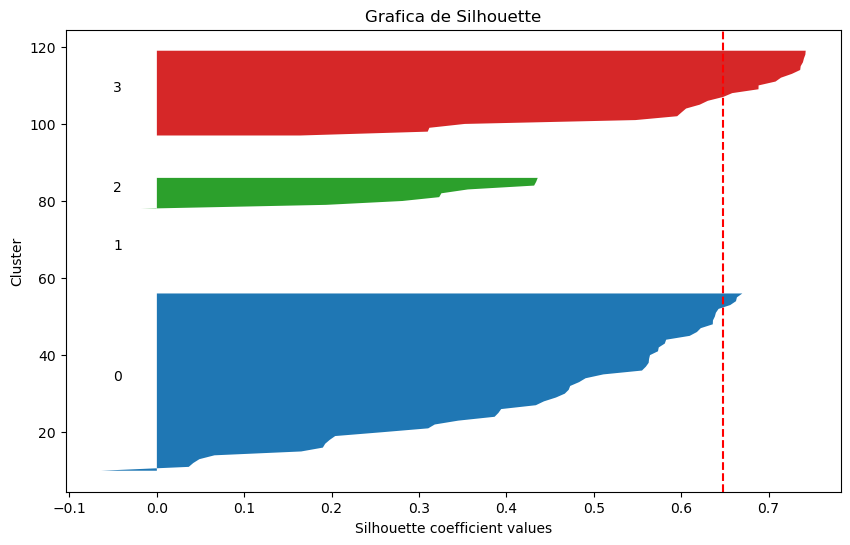

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

# Graficamos Silhouette score.

pred_pd = predictions.select("features", "prediction").toPandas()
X = np.vstack(pred_pd["features"].values)
labels = pred_pd["prediction"].values

sample_values = silhouette_samples(X, labels)

plt.figure(figsize=(10, 6))
y_lower = 10
for i in np.unique(labels):
    ith_cluster_silhouette_values = sample_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette, color="red", linestyle="--")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster")
plt.title("Grafica de Silhouette")
plt.show()

In [54]:
# Juntar las previsiones de cluster con la tabla RFM final
clientes_clusterizados = rfm_final.join(predictions.select("customer_id", col("prediction").alias("cluster")), "customer_id", "inner")
print("Tabela final com RFM Scores e Cluster:")
clientes_clusterizados.show(10)

Tabela final com RFM Scores e Cluster:
+-----------+--------+----------+------------------+-------+-------+-------+---------+-------+
|customer_id|Recencia|Frequencia|         Monetario|R_Score|F_Score|M_Score|RFM_Score|cluster|
+-----------+--------+----------+------------------+-------+-------+-------+---------+-------+
|         26|     215|        53|218783.79999999996|      3|      4|      5|      345|      2|
|         29|     154|        26| 72460.25999999998|      4|      4|      5|      445|      2|
|         30|     192|        19|43949.100000000006|      3|      4|      5|      345|      0|
|         43|     149|        27|          65978.52|      4|      4|      5|      445|      2|
|         60|     200|        30|          79364.44|      3|      4|      5|      345|      2|
|         69|     361|         1|            1439.6|      1|      2|      2|      122|      3|
|         72|     382|         1|           1683.86|      1|      2|      2|      122|      3|
|         7

In [55]:
# Analisar las características de cada cluster
print("\nAnálise das características médias por cluster:")
clientes_clusterizados.groupBy("cluster") \
    .agg(avg("Recencia").alias("Recencia_Media"), \
         avg("Frequencia").alias("Frequencia_Media"), \
         avg("Monetario").alias("Monetario_Medio"), \
         countDistinct("customer_id").alias("Num_Clientes")) \
    .orderBy("cluster") \
    .show()


Análise das características médias por cluster:
+-------+------------------+------------------+------------------+------------+
|cluster|    Recencia_Media|  Frequencia_Media|   Monetario_Medio|Num_Clientes|
+-------+------------------+------------------+------------------+------------+
|      0|183.04255319148936|  5.51063829787234|14892.252765957457|          47|
|      1|             133.0|             172.0| 528263.5800000001|           1|
|      2|174.55555555555554|28.444444444444443|106955.37310666667|           9|
|      3| 295.0869565217391|1.3043478260869565|2943.0739130434786|          23|
+-------+------------------+------------------+------------------+------------+



6. Modelo de Recomendação de Produtos (ALS - Collaborative Filtering)

In [56]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import expr

In [57]:
# Certificar que os IDs são inteiros e não nulos
als_data = df_ordens.select(
    col("customer_id").cast(IntegerType()),
    col("product_id").cast(IntegerType()),
    col("product_qty").cast(FloatType()) # Usando cantidad como 'rating' implícito
).na.drop() # Quitar lineas donde customer_id o product_id son nulos mismo despues del cast

In [58]:
# renombrar columnas para el patron de ALS
als_data = als_data.withColumnRenamed("customer_id", "userCol") \
                   .withColumnRenamed("product_id", "itemCol") \
                   .withColumnRenamed("product_qty", "ratingCol")

In [59]:
# Dividir datos en train y test 
(training, test) = als_data.randomSplit([0.8, 0.2], seed=1234)

In [60]:
# Construir modelo ALS con una configuracion basica
als_model = ALS(userCol="userCol", itemCol="itemCol", ratingCol="ratingCol",
          implicitPrefs=True, coldStartStrategy="drop",
          nonnegative=True)

In [62]:
from pyspark.sql.functions import explode
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# test de los hiperparametros para ajuste.
paramGrid = ParamGridBuilder() \
    .addGrid(als_model.rank, [10, 20, 30]) \
    .addGrid(als_model.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(als_model.alpha, [0.5, 1.0, 2.0]) \
    .build()


#cross validator Evaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="ratingCol", predictionCol="prediction")

cv = CrossValidator(estimator=als_model,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)

# Entrenar el modelo
cv_model = cv.fit(training)

# Mejor modelo
mejor_modelo = cv_model.bestModel

# Previsiones en el conjunto de test
previsoes = mejor_modelo.transform(test)

# Cálculo de RMSE y MAE
rmse = evaluator.evaluate(previsoes.na.drop(subset=["prediction"]))
print(f"Melhor RMSE no teste: {rmse}")
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="ratingCol", predictionCol="prediction")
mae = evaluator_mae.evaluate(previsoes)
print(f"Mean Absolute Error (MAE):    {mae:.4f}")

# Generar las recomendaciones formatadas
recomendaciones = mejor_modelo.recommendForAllUsers(5)


Melhor RMSE no teste: 75.3878123470439
Mean Absolute Error (MAE):    14.5052


In [63]:
print("Top 5 Recomendaciones por usuario (IDs de Produto):")
recomendaciones.show(10, truncate=False)

Top 5 Recomendaciones por usuario (IDs de Produto):
+-------+----------------------------------------------------------------------------------------------------------------+
|userCol|recommendations                                                                                                 |
+-------+----------------------------------------------------------------------------------------------------------------+
|580    |[{5674, 0.81703234}, {20412, 0.795498}, {19808, 0.78540576}, {14536, 0.7109094}, {17766, 0.6718696}]            |
|470    |[{5674, 0.95439374}, {20412, 0.92168146}, {19808, 0.9102767}, {14536, 0.81114125}, {17766, 0.7665971}]          |
|430    |[{2678, 1.1936221}, {13610, 1.1393023}, {13609, 1.1090592}, {16620, 1.099915}, {10594, 1.0756879}]              |
|450    |[{13442, 0.8765648}, {12936, 0.69863206}, {1584, 0.5896245}, {14745, 0.5780283}, {14288, 0.5502549}]            |
|80     |[{11668, 1.0677543}, {4189, 1.0367855}, {16596, 1.015159}, {5095, 1.0010126}, 

In [64]:
# Formatear las recomendaciones para mejor visualizarlas
user_recs_formatted = recomendaciones.withColumn("rec_exp", expr("explode(recommendations)")) \
                               .select("userCol", col("rec_exp.itemCol").alias("product_id"), col("rec_exp.rating").alias("predicted_rating"))
print("Recomendaciones formateadas (Usuário, Produto ID, Rating Predito):")
user_recs_formatted.show(20)

Recomendaciones formateadas (Usuário, Produto ID, Rating Predito):
+-------+----------+----------------+
|userCol|product_id|predicted_rating|
+-------+----------+----------------+
|    580|      5674|      0.81703234|
|    580|     20412|        0.795498|
|    580|     19808|      0.78540576|
|    580|     14536|       0.7109094|
|    580|     17766|       0.6718696|
|    470|      5674|      0.95439374|
|    470|     20412|      0.92168146|
|    470|     19808|       0.9102767|
|    470|     14536|      0.81114125|
|    470|     17766|       0.7665971|
|    430|      2678|       1.1936221|
|    430|     13610|       1.1393023|
|    430|     13609|       1.1090592|
|    430|     16620|        1.099915|
|    430|     10594|       1.0756879|
|    450|     13442|       0.8765648|
|    450|     12936|      0.69863206|
|    450|      1584|       0.5896245|
|    450|     14745|       0.5780283|
|    450|     14288|       0.5502549|
+-------+----------+----------------+
only showing top 20 r

In [65]:
# Juntar con nombres de productos para que sean mas legíveis
# Seleccionar apenas id e nombre del producto para el join
df_produtos_nomes = df_produtos.select(col("product_id").cast(IntegerType()), "post_title")

user_recs_final = user_recs_formatted.join(df_produtos_nomes, user_recs_formatted.product_id == df_produtos_nomes.product_id, "left") \
                                  .select(
    col("userCol"),
    df_produtos_nomes.product_id.alias("product_id"),
    col("post_title"),
    col("predicted_rating")
)

In [ ]:
# Agruparlos para ver los top 5 por usuário de forma mais clara
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, collect_list
from pyspark.sql.functions import struct

window_spec = Window.partitionBy("userCol").orderBy(col("predicted_rating").desc())

user_recs_grouped = user_recs_final \
    .withColumn("rank", rank().over(window_spec)) \
    .where(col("rank") <= 5) \
    .groupBy("userCol") \
    .agg(collect_list(struct("product_id", "post_title", "predicted_rating")).alias("top_5_recomendaciones"))
    
user_recs_grouped.show(10, truncate=False)

+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userCol|top_5_recomendacoes                                                                                                                                                                                                                                                                                   |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26     |[{614, HP 15-EF2747WM, 1.3718138}, {14215, ASROCK A520M PRO4, 1.3688942}, {1

#### CHURN

NO ESTÁ BIEN.

7. Modelo de Previsão de Churn

In [81]:
from pyspark.sql.functions import datediff, current_date, lit, avg as spark_avg, count as spark_count, max as spark_max, struct
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [82]:
# 7.1 Definição de Churn e Criação de Labels
# Definir churn: Cliente que não fez compra nos últimos X dias (ex: 90 dias)
# Este valor pode ser ajustado com base no conhecimento do negócio
churn_threshold_days = 90

In [83]:
# Usar a tabela RFM que já tem a Recência (dias desde a última compra)
# Se Recencia > churn_threshold_days, então churn = 1, senão 0
# Certificar que rfm_final está disponível
if 'rfm_final' not in locals():
    print("Erro: Tabela rfm_final não encontrada. Execute a etapa RFM primeiro.")
    # Adicionar código para recarregar ou recalcular rfm_final se necessário
    # Por exemplo:
    # rfm_r = df_ordens.groupBy("customer_id").agg(spark_min("recencia_ordem_dias").alias("Recencia"))
    # rfm_f = df_ordens.groupBy("customer_id").agg(countDistinct("order_id").alias("Frequencia"))
    # rfm_m = df_ordens.groupBy("customer_id").agg(spark_sum("product_gross_revenue").alias("Monetario"))
    # rfm_final = rfm_r.join(rfm_f, "customer_id", "inner").join(rfm_m, "customer_id", "inner")

In [84]:
churn_labels = rfm_final.withColumn("churn_label",
                                    when(col("Recencia") > churn_threshold_days, 1).otherwise(0))

In [85]:
print(f"Definindo churn como inatividade > {churn_threshold_days} dias.")
churn_labels.groupBy("churn_label").count().show()

Definindo churn como inatividade > 90 dias.
+-----------+-----+
|churn_label|count|
+-----------+-----+
|          1|   80|
+-----------+-----+



In [86]:
# 7.2 Feature Engineering Adicional
# Juntar com df_clientes para obter 'dias_desde_registro'
# Certificar que df_clientes está disponível e processado
if 'df_clientes' not in locals() or 'dias_desde_registro' not in df_clientes.columns:
     print("Erro: df_clientes ou coluna 'dias_desde_registro' não encontrada.")
     # Recarregar/reprocessar df_clientes se necessário
     # df_clientes = spark.read.csv(path_clientes, header=True, inferSchema=True, sep=',')
     # df_clientes = df_clientes.dropDuplicates(['user_id'])
     # df_clientes = df_clientes.withColumn("user_registered_ts", to_timestamp(col("user_registered"), "yyyy-MM-dd HH:mm:ss"))
     # df_clientes = df_clientes.withColumn("dias_desde_registro", datediff(current_date(), col("user_registered_ts")))

In [87]:
churn_data = churn_labels.join(df_clientes.select(col("user_id").alias("customer_id_ref"), "dias_desde_registro"),
                               churn_labels.customer_id == col("customer_id_ref"), "left") \
                         .select("customer_id", "Recencia", "Frequencia", "Monetario", "dias_desde_registro", "churn_label") \
                         .na.fill(0, subset=["dias_desde_registro"]) # Preencher nulos em dias_desde_registro (ex: se cliente não encontrado)

In [88]:
print("Dados preparados para modelo de churn:")
churn_data.show(5)

Dados preparados para modelo de churn:
+-----------+--------+----------+-----------------+-------------------+-----------+
|customer_id|Recencia|Frequencia|        Monetario|dias_desde_registro|churn_label|
+-----------+--------+----------+-----------------+-------------------+-----------+
|        737|     134|         2|          4715.28|                  0|          1|
|        516|     154|         1|           1044.3|                  0|          1|
|        580|     197|         2|           1770.0|                  0|          1|
|        513|     198|        13|50761.23999999999|                  0|          1|
|        613|     210|         1|           1534.0|                  0|          1|
+-----------+--------+----------+-----------------+-------------------+-----------+
only showing top 5 rows



In [89]:
# 7.3 Preparação para Modelagem (VectorAssembler, Scaler, Split)
# Colunas de features
feature_cols = ["Recencia", "Frequencia", "Monetario", "dias_desde_registro"]

In [90]:
# Montar vetor de features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw", handleInvalid="skip") # Skip rows with nulls

In [91]:
# Escalar features numéricas (importante para regressão logística)
scaler_churn = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)

In [92]:
# Criar pipeline para pré-processamento
preprocess_pipeline = Pipeline(stages=[assembler, scaler_churn])
preprocess_model = preprocess_pipeline.fit(churn_data)
final_churn_data = preprocess_model.transform(churn_data)

In [93]:
# Selecionar colunas finais e renomear label
final_churn_data = final_churn_data.select(col("customer_id"), col("features"), col("churn_label").alias("label"))

In [94]:
print("Dados finais com features escaladas e label:")
final_churn_data.show(5, truncate=False)

Dados finais com features escaladas e label:
+-----------+------------------------------------------------------------------------------------+-----+
|customer_id|features                                                                            |label|
+-----------+------------------------------------------------------------------------------------+-----+
|737        |[-1.2204026035000965,-0.33474376723009847,-0.34684949808465804,-0.6423398862187408] |1    |
|516        |[-0.9020713081626082,-0.3828218666527338,-0.40099505711315014,-0.6423398862187408]  |1    |
|580        |[-0.21765902318700828,-0.33474376723009847,-0.39029125807665943,-0.6423398862187408]|1    |
|513        |[-0.20174245842013386,0.1941153264188905,0.3323109019184983,-0.6423398862187408]    |1    |
|613        |[-0.010743681217640863,-0.3828218666527338,-0.39377216833242873,-0.6423398862187408]|1    |
+-----------+------------------------------------------------------------------------------------+-----+
only showi

In [95]:
# Verificar se há dados suficientes após pré-processamento
if final_churn_data.count() == 0:
    print("Erro: Nenhum dado restante após pré-processamento para o modelo de churn.")
else:
    # Dividir em treino e teste
    (train_data, test_data) = final_churn_data.randomSplit([0.8, 0.2], seed=42)
    print(f"Registros de treino: {train_data.count()}, Registros de teste: {test_data.count()}")

    # 7.4 Treinamento do Modelo (Ex: Regressão Logística)
    if train_data.count() > 0:
        lr = LogisticRegression(featuresCol="features", labelCol="label")
        lr_model = lr.fit(train_data)
        print("Modelo de Regressão Logística treinado.")

        # 7.5 Avaliação do Modelo
        if test_data.count() > 0:
            predictions_lr = lr_model.transform(test_data)
            print("Predições no conjunto de teste:")
            predictions_lr.select("customer_id", "label", "probability", "prediction").show(10, truncate=False)

            # Avaliar usando AUC
            evaluator_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
            # Lidar com possíveis NaNs na coluna de predição se houver
            auc = evaluator_auc.evaluate(predictions_lr.na.drop(subset=["rawPrediction"]))
            print(f"Área sob a curva ROC (AUC) no conjunto de teste: {auc}")

            # Avaliar usando outras métricas (Accuracy, Precision, Recall, F1)
            evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
            accuracy = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "accuracy"})
            precision = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "weightedPrecision"})
            recall = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "weightedRecall"})
            f1 = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "f1"})

            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1 Score: {f1}")
        else:
            print("Não há dados de teste suficientes para avaliação.")
    else:
        print("Não há dados de treino suficientes para treinar o modelo.")

Registros de treino: 63, Registros de teste: 17
Modelo de Regressão Logística treinado.
Predições no conjunto de teste:
+-----------+-----+-----------+----------+
|customer_id|label|probability|prediction|
+-----------+-----+-----------+----------+
|30         |1    |[0.0,1.0]  |1.0       |
|72         |1    |[0.0,1.0]  |1.0       |
|80         |1    |[0.0,1.0]  |1.0       |
|172        |1    |[0.0,1.0]  |1.0       |
|244        |1    |[0.0,1.0]  |1.0       |
|260        |1    |[0.0,1.0]  |1.0       |
|279        |1    |[0.0,1.0]  |1.0       |
|327        |1    |[0.0,1.0]  |1.0       |
|432        |1    |[0.0,1.0]  |1.0       |
|435        |1    |[0.0,1.0]  |1.0       |
+-----------+-----+-----------+----------+
only showing top 10 rows

Área sob a curva ROC (AUC) no conjunto de teste: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [108]:
# 1. Avaliador AUC e AUC-PR
evaluator_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
evaluator_pr = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderPR")

# Lidar com possíveis NaNs na coluna de predição se houver (ex: coldStartStrategy)
valid_predictions = predictions_lr.na.drop(subset=["rawPrediction", "prediction", "label"])

if valid_predictions.count() == 0:
    print("Não há predições válidas para avaliação após remover NaNs.")
else: 
    print("Há predições válidas para avaliação após remover NaNs.")

Há predições válidas para avaliação após remover NaNs.


In [109]:
auc_score = evaluator_auc.evaluate(valid_predictions)
pr_auc_score = evaluator_pr.evaluate(valid_predictions)
print(f"Área sob a Curva ROC (AUC): {auc_score:.4f}")
print(f"Área sob a Curva Precision-Recall (AUC-PR): {pr_auc_score:.4f}")



Área sob a Curva ROC (AUC): 1.0000
Área sob a Curva Precision-Recall (AUC-PR): 1.0000


In [110]:
# 2. Avaliador Multiclasse para Accuracy, Precision, Recall, F1
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "accuracy"})
precision_w = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall_w = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "weightedRecall"})
f1_w = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "f1"})

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision Ponderada: {precision_w:.4f}")
print(f"Recall Ponderado: {recall_w:.4f}")
print(f"F1-Score Ponderado: {f1_w:.4f}")




Accuracy: 1.0000
Precision Ponderada: 1.0000
Recall Ponderado: 1.0000
F1-Score Ponderado: 1.0000


In [115]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Verifique as labels presentes
present_labels = valid_predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

for label in present_labels:
    precision = evaluator_multi.evaluate(valid_predictions, {
        evaluator_multi.metricName: "precisionByLabel",
        evaluator_multi.metricLabel: label
    })
    recall = evaluator_multi.evaluate(valid_predictions, {
        evaluator_multi.metricName: "recallByLabel",
        evaluator_multi.metricLabel: label
    })
    f1 = evaluator_multi.evaluate(valid_predictions, {
        evaluator_multi.metricName: "f1",
        evaluator_multi.metricLabel: label
    })

    print(f"Label {label}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

# 3. Métricas por Classe
print("\n-- Métricas por Classe --")
labels = [0.0, 1.0]
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# 🔍 Verifique quais classes realmente estão presentes
labels_presentes = valid_predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

print("\n-- Métricas por Classe (presentes nos dados) --")
for label in sorted(labels_presentes):
    evaluator.setMetricLabel(label)

    evaluator.setMetricName("precisionByLabel")
    precision = evaluator.evaluate(valid_predictions)

    evaluator.setMetricName("recallByLabel")
    recall = evaluator.evaluate(valid_predictions)

    evaluator.setMetricName("f1")
    f1 = evaluator.evaluate(valid_predictions)

    print(f"Label {label}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

    


Label 1: Precision = 1.0000, Recall = 1.0000, F1 = 1.0000

-- Métricas por Classe --

-- Métricas por Classe (presentes nos dados) --
Label 1: Precision = 1.0000, Recall = 1.0000, F1 = 1.0000


In [116]:
# 4. Matriz de Confusão (Cálculo com PySpark)
print("\n-- Matriz de Confusão --")
# Calcula TP, TN, FP, FN diretamente
tp = valid_predictions.filter("label = 1.0 AND prediction = 1.0").count()
tn = valid_predictions.filter("label = 0.0 AND prediction = 0.0").count()
fp = valid_predictions.filter("label = 0.0 AND prediction = 1.0").count()
fn = valid_predictions.filter("label = 1.0 AND prediction = 0.0").count()

print(f"                 Predito 0 | Predito 1")
print(f"Real 0 (Não Churn):  {tn:^8} | {fp:^8}")
print(f"Real 1 (Churn):      {fn:^8} | {tp:^8}")


-- Matriz de Confusão --
                 Predito 0 | Predito 1
Real 0 (Não Churn):     0     |    0    
Real 1 (Churn):         0     |    17   


Próximo passo: Finalizar e entregar o notebook

In [ ]:
# Finalizar SparkSession
spark.stop()
print("SparkSession finalizada.")